#`This notebook is an illustration to create a Sentiment Analyzer with BERT by Hugging Face using PyTorch`😇🤗

For more information, check out the [Bert Documentation](https://huggingface.co/transformers/model_doc/bert.html).

<img src="https://miro.medium.com/max/2960/0*63_xsVQp0Wezk9ua.jpg" alt="Simply Easy Learning" width="350"
         height="200"> 
  
    

The [BERT paper](https://arxiv.org/abs/1810.04805) was released along with the [source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance.

## **Setup**
Install the required packages and setup the imports: 

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers 

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# Dataset Exploration
We'll load the Google Play app reviews dataset, that we've put together in the notebook (Custom Dataset)

In [4]:
!gdown --id 1jWBK-rBSbtSY9Mtr_AEELeb4psvvMKwq

Downloading...
From: https://drive.google.com/uc?id=1jWBK-rBSbtSY9Mtr_AEELeb4psvvMKwq
To: /content/reviews(20APPS).csv
10.9MB [00:00, 171MB/s]


In [5]:
df = pd.read_csv("reviews(20APPS).csv")
df.head() 

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEtpLcODD_NZOBqR1N7DBbaLdw3Gyz3v3xZAp1...,Mad Scientist,https://lh3.googleusercontent.com/-kIZF4kMt6yY...,"Unable to register with an email. Clicking""con...",1,6,5.2.0.9,2020-07-10 17:59:22,We are unaware of any issues with signing in t...,2020-07-12 08:02:19,most_relevant,com.anydo
1,gp:AOqpTOGG5EdQ69VnyUoJ2bJ4jB_hWqNeLh9nZ-ULOVz...,Sergey P,https://lh3.googleusercontent.com/a-/AOh14GgVZ...,Any.Forget... Had an instance of daily repeati...,1,11,5.2.0.9,2020-07-08 09:37:48,Our team will be happy to look into this issue...,2020-07-09 08:19:41,most_relevant,com.anydo
2,gp:AOqpTOFP7H5aFBDA-Bd_w7e2A-19zZffNJbbH1OL-CY...,Jay Nishimura,https://lh3.googleusercontent.com/a-/AOh14GhJ7...,"It works okay, But I did not consent to subscr...",1,27,5.2.0.9,2020-07-06 09:51:44,A payment can only be made upon the user's aut...,2020-07-07 11:01:27,most_relevant,com.anydo
3,gp:AOqpTOEF7Dt1m_v8AlD_EcsuXBiLKDZJxNANOVM8ohA...,Tom Larkin,https://lh3.googleusercontent.com/-rQ0FefEbngc...,Ruined the app by trying to get too fancy. My ...,1,5,5.2.0.9,2020-07-03 17:20:36,Please note that we've recently released a new...,2020-07-07 10:29:07,most_relevant,com.anydo
4,gp:AOqpTOF3Kb-6IdEeeYLcuUncmzjQdtNguLU5GTshqNY...,A Traveller,https://lh3.googleusercontent.com/-yutN8c-KH6U...,This app is a prime example of building a moun...,1,23,5.0.0.11,2020-05-09 17:20:56,If you're having trouble figuring out how to t...,2020-05-12 08:22:05,most_relevant,com.anydo


In [6]:
df.shape 

(20020, 12)

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20020 entries, 0 to 20019
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              20020 non-null  object
 1   userName              20020 non-null  object
 2   userImage             20020 non-null  object
 3   content               20018 non-null  object
 4   score                 20020 non-null  int64 
 5   thumbsUpCount         20020 non-null  int64 
 6   reviewCreatedVersion  17163 non-null  object
 7   at                    20020 non-null  object
 8   replyContent          9135 non-null   object
 9   repliedAt             9135 non-null   object
 10  sortOrder             20020 non-null  object
 11  appId                 20020 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.8+ MB


There is no missing values in the score and review texts! 
Is our data imbalanced?

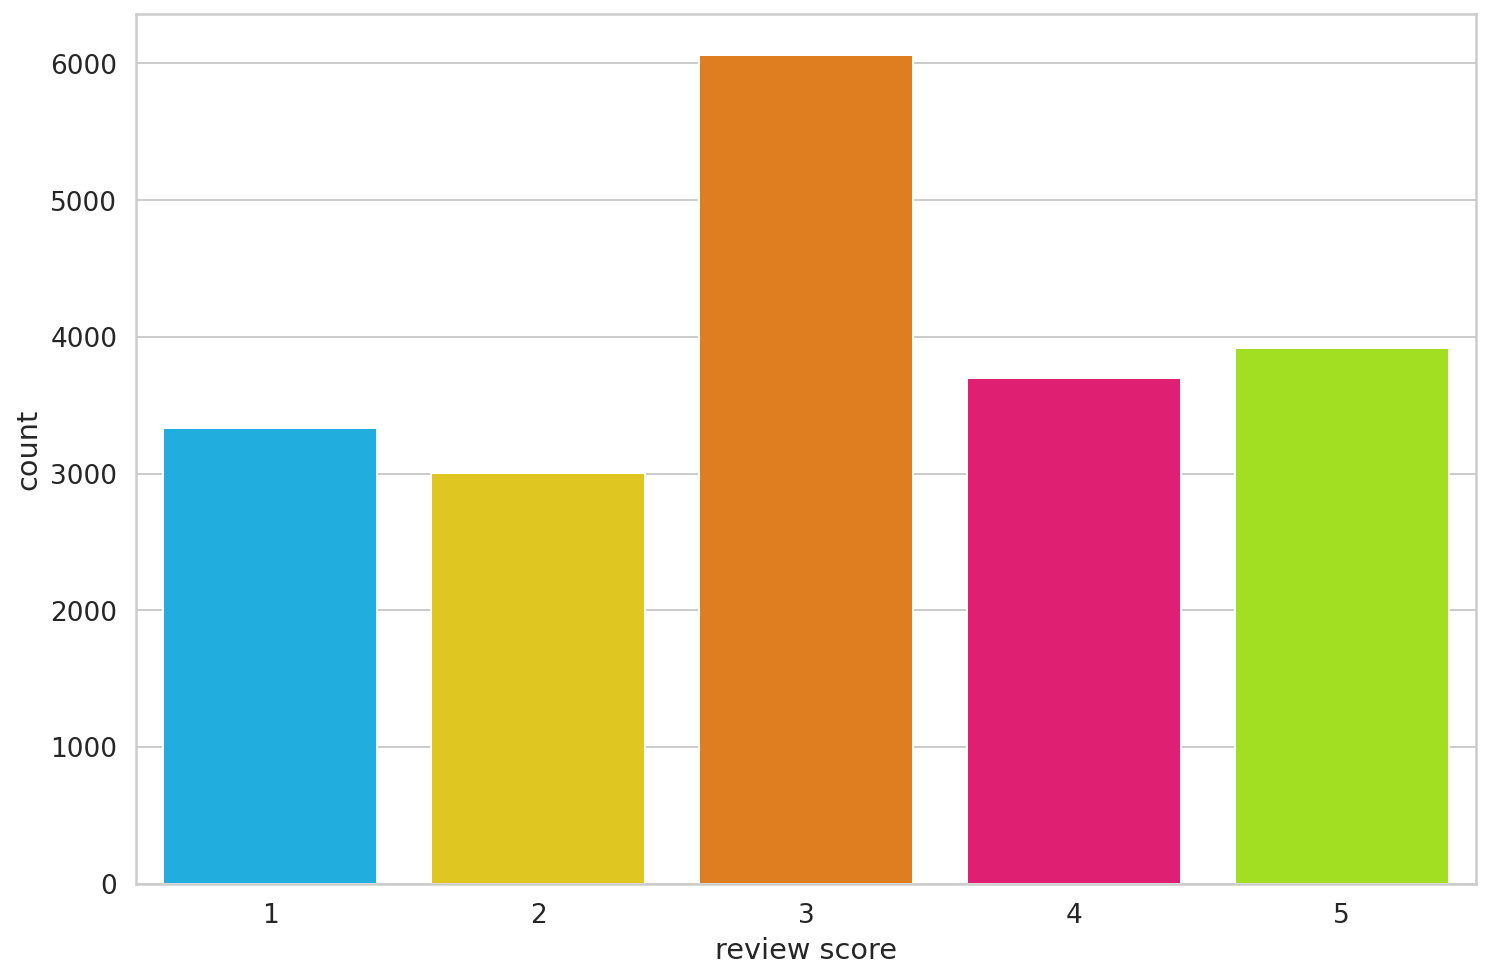

In [8]:
sns.countplot(df.score)
plt.xlabel('review score'); 

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [9]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating <=3.5:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment) 

In [10]:
class_names = ['negative', 'neutral', 'positive'] 

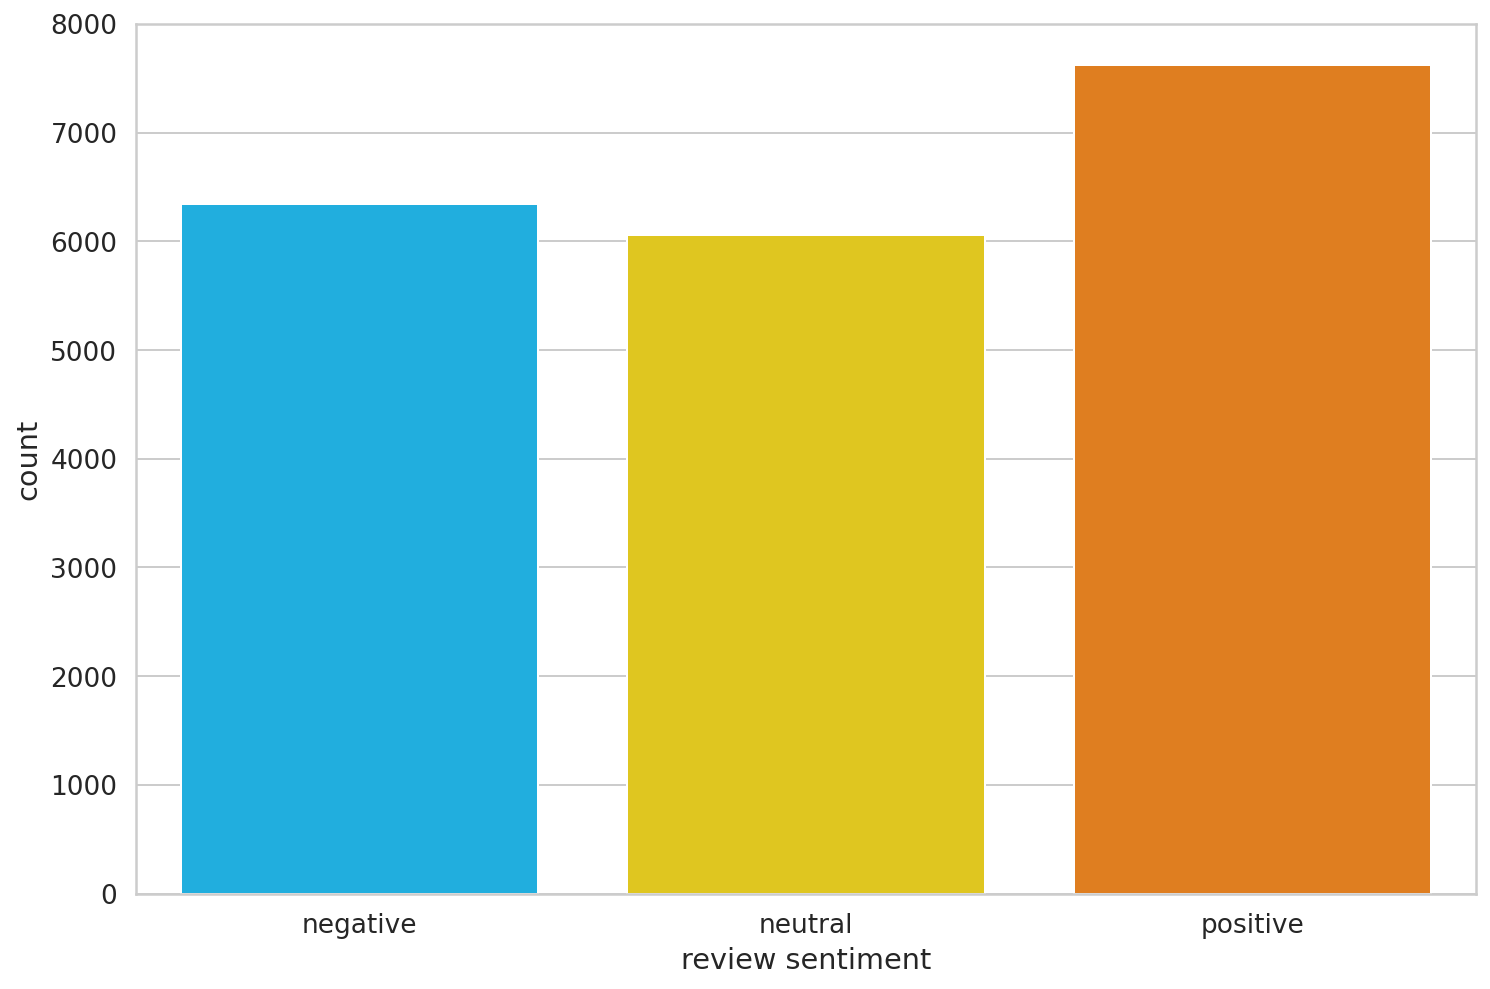

In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

# Data Preprocessing
Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch. It also includes prebuild tokenizers that does all the work for us.

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' 

`You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".`


Loading a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) 

Example to understand tokenization:

In [14]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.' 

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [15]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}') 

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


**Special Tokens**



[SEP] - marker for ending of a sentence

In [16]:
tokenizer.sep_token, tokenizer.sep_token_id 

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification 

In [17]:
tokenizer.cls_token, tokenizer.cls_token_id 

('[CLS]', 101)

There is also a special token for padding: 

In [18]:
tokenizer.pad_token, tokenizer.pad_token_id 

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token:  

In [19]:
tokenizer.unk_token, tokenizer.unk_token_id 

('[UNK]', 100)

All of that work can be done using the [encode_plus()](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [20]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys() 

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32: 

In [21]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0] 

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length: 

In [22]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'] 

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


We can inverse the tokenization to have a look at the special tokens: 

In [23]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [24]:
MAX_LEN = 160 

We have all building blocks required to create a PyTorch dataset. Let's do it: 

In [25]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    } 

The tokenizer is doing most of the work for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [26]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED) 

In [27]:
df_train.shape, df_val.shape, df_test.shape

((18018, 13), (1001, 13), (1001, 13))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
  ) 

In [29]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE) 

In [ ]:
data = next(iter(train_data_loader))
data.keys() 

In [31]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face
There are a lot of helper functions that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification),    [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) ,etc

We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [32]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) 

And try to use it on the encoding of our sample text:

In [33]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
) 

The last_hidden_state is a sequence of hidden states in the last layer of the model. Obtaining the pooled_output is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on last_hidden_state:

In [34]:
last_hidden_state.shape 

torch.Size([1, 32, 768])


We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [35]:
bert_model.config.hidden_size 

768

You can think of the pooled_output as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output: 

In [36]:
pooled_output.shape 

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [37]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output) 

 Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. 

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [38]:
model = SentimentClassifier(len(class_names))
model = model.to(device) 

In [39]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs: 

In [40]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4314, 0.1567, 0.4119],
        [0.4990, 0.1486, 0.3524],
        [0.2796, 0.1545, 0.5660],
        [0.5753, 0.1122, 0.3125],
        [0.5672, 0.1784, 0.2545],
        [0.3546, 0.1636, 0.4817],
        [0.3898, 0.1325, 0.4776],
        [0.3369, 0.2389, 0.4242],
        [0.3358, 0.1681, 0.4961],
        [0.2635, 0.2136, 0.5230],
        [0.4199, 0.1585, 0.4216],
        [0.3958, 0.2266, 0.3776],
        [0.5722, 0.0871, 0.3406],
        [0.4846, 0.1401, 0.3754],
        [0.3970, 0.1624, 0.4406],
        [0.3579, 0.1962, 0.4458]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## Training
To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [41]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device) 

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

*We're going to ignore the number of epochs recommendation but stick with the rest.*

**Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.**

In [42]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses) 

In [43]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses) 

# Loading pre-trained Model

In [44]:
!gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Downloading...
From: https://drive.google.com/uc?id=1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
To: /content/best_model_state.bin
433MB [00:02, 161MB/s]


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test) 
)

test_acc.item()

In [46]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values 

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [48]:
print(classification_report(y_test, y_pred, target_names=class_names)) 

              precision    recall  f1-score   support

    negative       0.86      0.82      0.84       323
     neutral       0.70      0.80      0.75       292
    positive       0.89      0.83      0.86       386

    accuracy                           0.82      1001
   macro avg       0.82      0.82      0.82      1001
weighted avg       0.83      0.82      0.82      1001



Looks like it is really hard to classify neutral (3 stars) reviews.

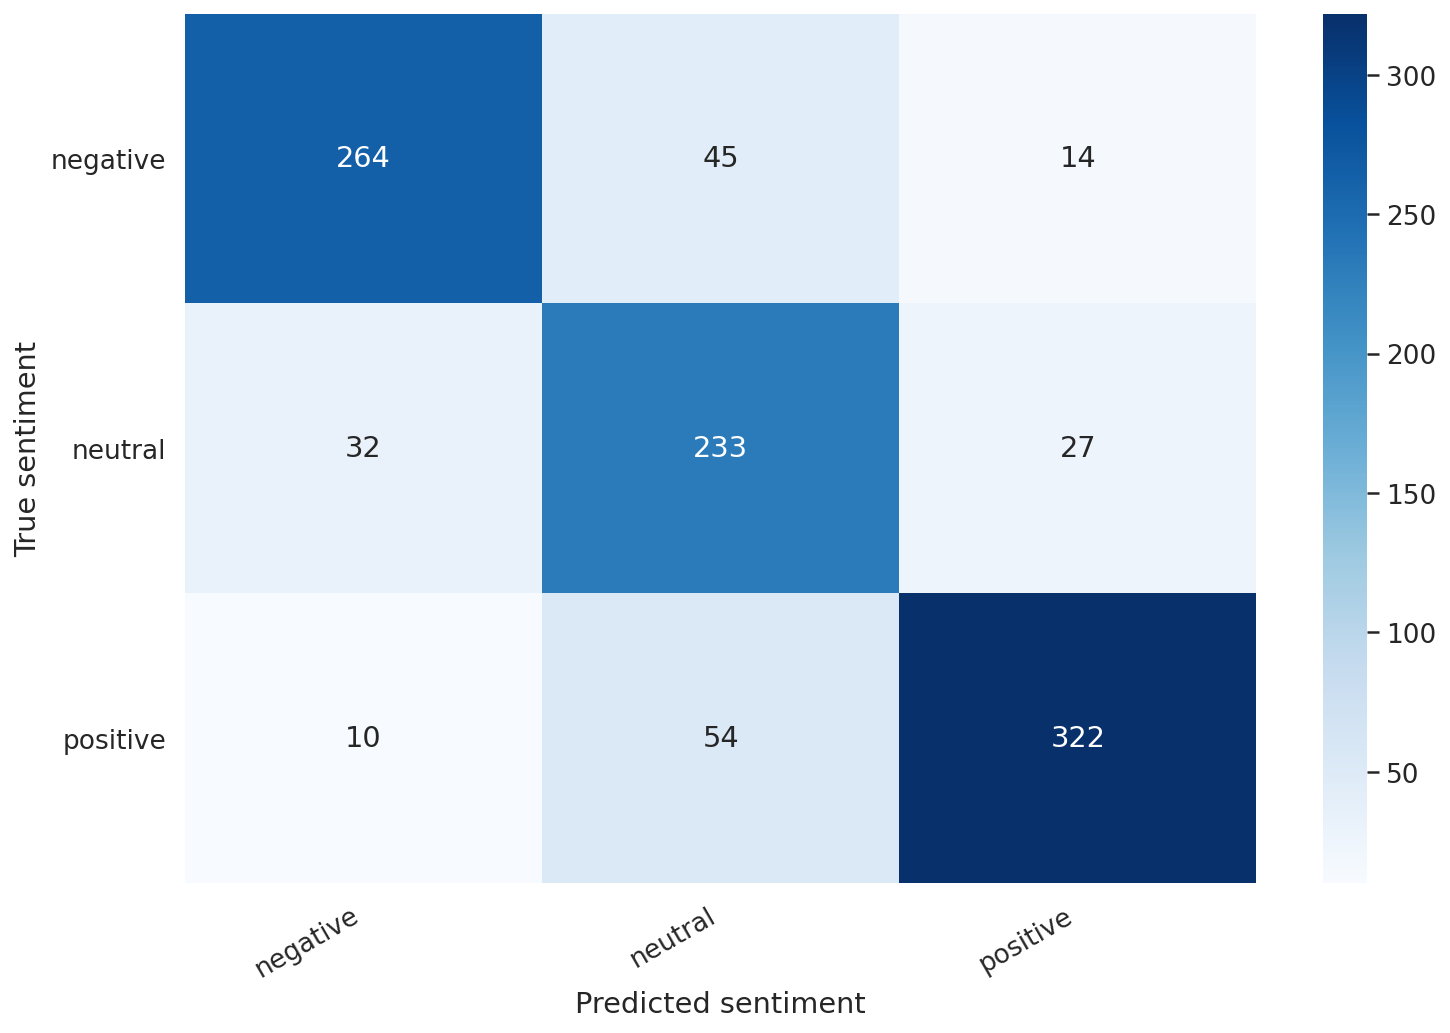

In [49]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm) 

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

 

## Predicting on Raw Text
Let's use our model to predict the sentiment of some raw text:

In [50]:
review_text = "I love completing this app! Best app ever!!!"

In [51]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt'
) 

In [52]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}') 

Review text: I love completing this app! Best app ever!!!
Sentiment  : positive


## Summary

You now have learned to:

* Intuitively understand what BERT is
* Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
* Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
* Evaluate the model on test data
* Predict sentiment on raw text

## References
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
-  [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)